In [122]:
import os
import numpy as np
import pandas as pd
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
import sklearn.metrics as skm
import matplotlib.pyplot as plt
%matplotlib notebook

##Load in the data

vocab=np.loadtxt('out_vocab_5.txt',dtype=bytes,delimiter='\n').astype(str)
trainX=np.genfromtxt('out_bag_of_words_5.csv',delimiter=',', dtype=int)
testX=np.genfromtxt('test_bag_of_words_0.csv',delimiter=',', dtype=int)
trainY= np.loadtxt('out_classes_5.txt' , delimiter=',',skiprows=0, usecols=[0], dtype=int) 
testY= np.loadtxt('test_classes_0.txt' , delimiter=',',skiprows=0, usecols=[0], dtype=int) 

## Data merging for cross-validation

Xarray = [trainX, testX]
X=np.vstack(Xarray)
Y=np.concatenate((trainY, testY), axis = 0)

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.4, random_state=0)

class manageFeatures:
    
    def addFeaturePairs(trainX,testX,vocab):
        k=len(trainX[0,:])
        trainXpairs=[]
        testXpairs=[]
        newvocab=[]
        for i in range(k):
            for j in range(i+1,k):
                trainz=np.multiply(trainX[:,i],trainX[:,j])
                trainXpairs.append(trainz)
                testz=np.multiply(testX[:,i],testX[:,j])
                testXpairs.append(testz)
                newvocab.append(vocab[i]+","+vocab[j])
        trainXpairs=np.transpose(trainXpairs)
        testXpairs=np.transpose(testXpairs)
        return [np.concatenate((trainX, trainXpairs), axis=1),np.concatenate((testX, testXpairs),axis=1),np.concatenate((vocab, newvocab))]
    
    def screenFeatures(trainY,trainX,testX,K,vocab):
        h=len(trainX[0,:])
        mut_info_scores=[skm.mutual_info_score(trainY, trainX[:,i]) for i in range(h)]
        cutoff=sorted(mut_info_scores)[h-K]
        count=K
        screened_trainX=[]
        screened_testX=[]
        screened_vocab=[]
        for i in range(h):
            if mut_info_scores[i]>=cutoff and count>0:
                screened_trainX.append(trainX[:,i])
                screened_testX.append(testX[:,i])
                screened_vocab.append(vocab[i])
                count=count-1
        return [np.transpose(screened_trainX),np.transpose(screened_testX),screened_vocab]
    
# Feature Selection Data
screened_trainX,screened_testX,screened_vocab=manageFeatures.screenFeatures(trainY,trainX,testX,200,vocab)

## Bigrams + Selected Feature Data
new_trainX,new_testX,newvocab=manageFeatures.addFeaturePairs(trainX,testX,vocab)
screened_new_trainX,screened_new_testX,screened_new_vocab=manageFeatures.screenFeatures(trainY,new_trainX,new_testX,500,newvocab)

<IPython.core.display.Javascript object>


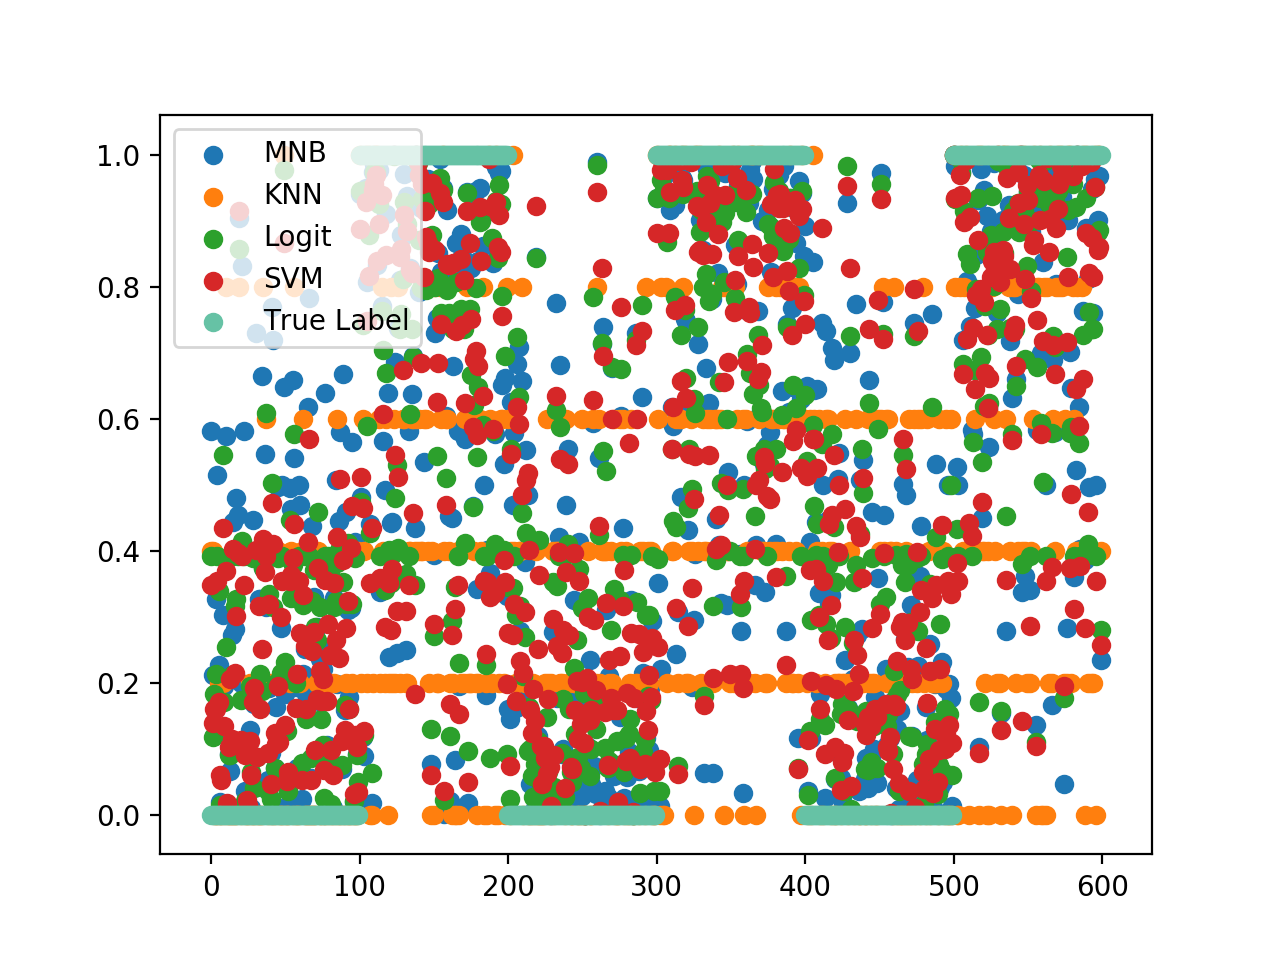

<IPython.core.display.Javascript object>


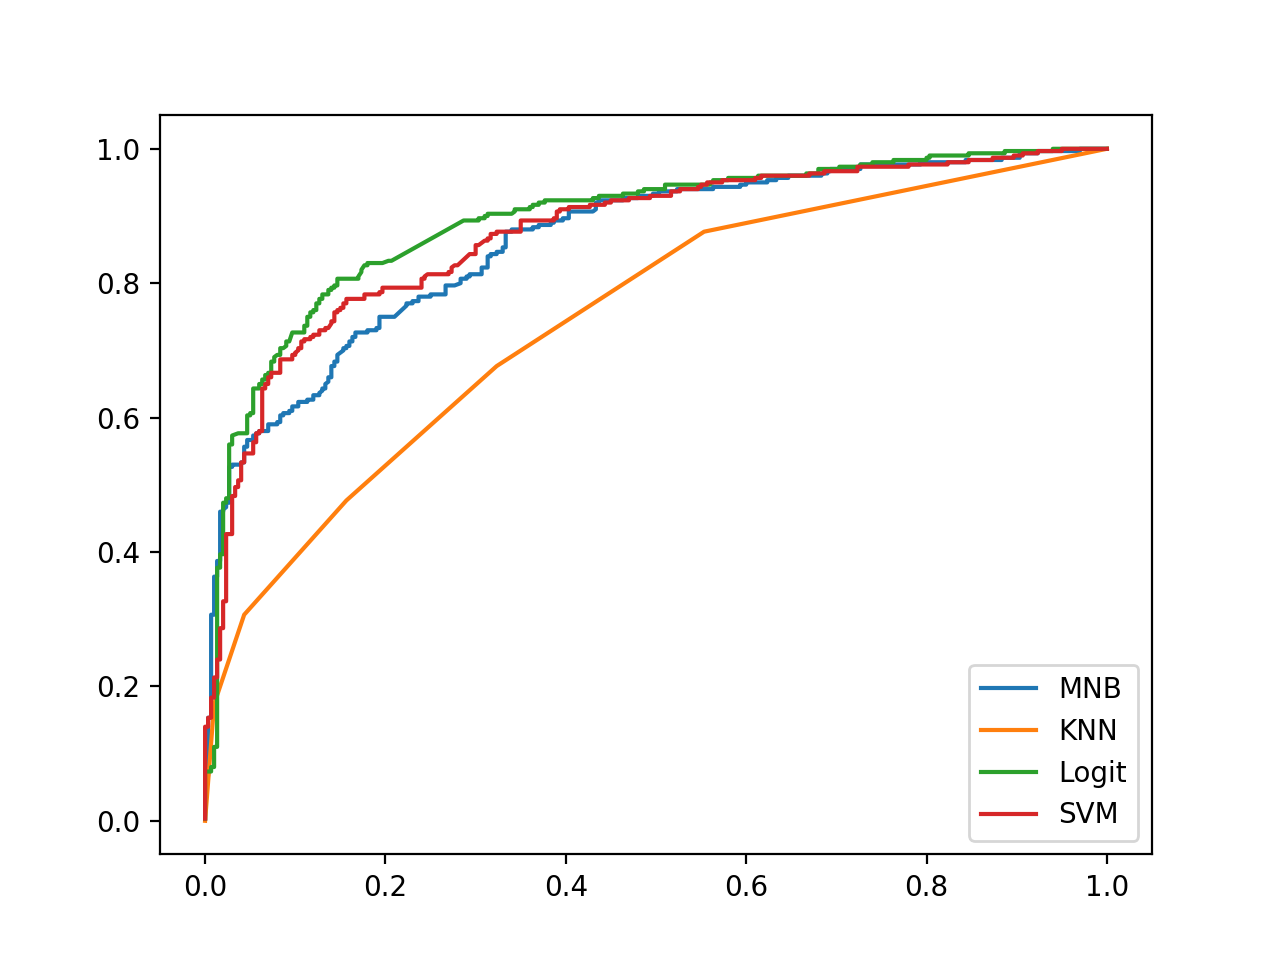

In [120]:
import brewer2mpl
# Get "Set2" colors from ColorBrewer (all colorbrewer scales: http://bl.ocks.org/mbostock/5577023)
set2 = brewer2mpl.get_map('Set2', 'qualitative', 8).mpl_colors

names = ["MNB", "KNN", "Logit", "SVM"
        ]

classifiers = [
    MultinomialNB(),
    KNeighborsClassifier(5),
    LogisticRegression(penalty='l1'),
    svm.SVC(kernel='linear', C=0.2, probability=True)
    ]

##Initialize dictionaries to record scoring criteria and misclassified test data

score = {}  
wrong_ids_false_negative = {}
wrong_ids_false_positive = {} 
wrong_ids_fn_screen = {}
wrong_ids_fp_screen = {} 

data = [trainX, testX]
screened_data = [screened_trainX, screened_testX]
screened_bigram_data = [screened_new_trainX, screened_new_testX]
k=0
def finish_plots():
    plt.figure(1)
    global k
    plt.scatter([i for i in range(len(testY))], testY, label='True Label', facecolor=set2[k])  
    k = k+ 1
    plt.legend()
    #plt.title('$P(c=1 | x_i)$ for test $x_i$')
    plt.show()
    plt.figure(2)
    plt.legend()
    #plt.title('ROC AUC Curves by Classifier')
    plt.show()

def do_analysis(name, clf, data, flag):
    # data = [trainX, testX]
    temp = 0
    trainX = data[0]
    testX = data[1]
    clf.fit(trainX, trainY)
    predictions = clf.predict(testX)
    probabilities = clf.predict_proba(testX)
    false_negs = [x for x, (prediction, truth) in enumerate(zip(predictions, testY)) 
                  if prediction != truth and prediction == 0]
    false_pos = [x for x, (prediction, truth) in enumerate(zip(predictions, testY)) 
                  if prediction != truth and prediction == 1]
    
    if flag == 0:
        plot_stuff(probabilities, name)
        wrong_ids_false_negative[name] = false_negs
        wrong_ids_false_positive[name] = false_pos
        scores = cross_val_score(clf, X, Y, cv=5) #Cross validation performance
        #temp = "%0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2)
        temp = scores.mean()
        
    if flag == 2:
        wrong_ids_fp_screen[name] = false_pos
        wrong_ids_fn_screen[name] = false_negs
    score[name] = (skm.roc_auc_score(testY, probabilities[:,1]), clf.score(testX, testY), temp)
    
def plot_stuff(probs, name):
    plt.figure(1)
    prob_class0 = [probs[i][1] for i in range(len(probs))]
    ids = [i for i in range(len(prob_class0))]
    plt.scatter(ids, prob_class0, label=name)
    plt.figure(2)
    false_pos, true_pos, thresholds = skm.roc_curve(testY, probs[:,1])
    plt.plot(false_pos,true_pos, label=name)

if __name__ == "__main__":
    for name, clf in zip(names, classifiers): 
        wrong_ids_false_positive[name] = []
        wrong_ids_false_negative[name] = []
        do_analysis(name, clf, data, 0)
    finish_plots() 
    names = ["MNB (S)", "KNN (S)", "Logit (S)", "SVM (S)"]
    for name, clf in zip(names, classifiers): 
        do_analysis(name, clf, screened_data, 1)
        
    names = ["MNB (S,B)", "KNN(S,B)", "Logit (S,B)", "SVM (S,B)"]    
    for name, clf in zip(names, classifiers): 
        wrong_ids_fp_screen[name] = []
        wrong_ids_fn_screen[name] = []
        do_analysis(name, clf, screened_bigram_data, 2)

In [121]:
# Make pandas data frame to display evaluation criteria
df = pd.DataFrame(data=score)
df.round(2)
#df.rename(index={0: 'ROC AUC Score'}, 1: '% Correctly Predicted', 2: 'Cross-Validation Accuracy'})
df = df.round(2)
# DF splits for Latex code
# df1 = df[['KNN','Logit', 'MNB', 'SVM']]
# df2= df[['MNB (S)','KNN (S)', 'Logit (S)', 'SVM (S)']]
# df3 = df[['MNB (S,B)', 'KNN (S,B)', 'Logit (S,B)', 'SVM (S,B)']]
df

,KNN,KNN (S),"KNN(S,B)",Logit,Logit (S),"Logit (S,B)",MNB,MNB (S),"MNB (S,B)",SVM,SVM (S),"SVM (S,B)"
0,0.75,0.77,0.80,0.89,0.86,0.88,0.86,0.84,0.87,0.87,0.85,0.88
1,0.66,0.70,0.76,0.82,0.79,0.81,0.77,0.76,0.80,0.80,0.78,0.80
2,0.69,0.00,0.00,0.78,0.00,0.00,0.77,0.00,0.00,0.78,0.00,0.00


In [58]:
def evaluate(wrong_ids):
    ##Takes in vector of wrong_ids for all classifiers and returns a dictionary of bad words with # of times they appear
    error_words = {}
    for key, value in wrong_ids.items():
        temp = [testX[value[i]] for i in range(len(value))] #saving the x_i that we messed up
                                                        # and translating x_i back into vocab
        for x in temp:
            bad_words = [vocab[index] for index, xi in enumerate(x) if xi != 0]
            for word in bad_words: 
                if word not in error_words.keys():
                    error_words[word] = 1
                else: 
                    error_words[word] += 1
    return error_words

error_words_false_positive = evaluate(wrong_ids_false_positive)
error_words_false_negative = evaluate(wrong_ids_false_negative)

false_pos = pd.DataFrame(data=sorted(error_words_false_positive.items(), key=lambda x:x[1], reverse=True))

In [44]:
false_pos = pd.DataFrame(data=sorted(error_words_false_positive.items(), key=lambda x:x[1], reverse=True))
false_neg =  pd.DataFrame(data=sorted(error_words_false_negative.items(), key=lambda x:x[1], reverse=True))
false_pos.head() #most commonly appearing word features in false positives

,0,1
0,good,24
1,film,20
2,one,12
3,make,10
4,look,9


In [45]:
false_neg.head() #most commonly appearing word features in false negatives

,0,1
0,film,28
1,get,27
2,place,27
3,good,25
4,one,25


In [47]:
error_fp_screen = evaluate(wrong_ids_fp_screen)
error_fn_screen = evaluate(wrong_ids_fn_screen)
false_pos_screen = pd.DataFrame(data=sorted(error_fp_screen.items(), key=lambda x:x[1], reverse=True))
false_neg_screen =  pd.DataFrame(data=sorted(error_fn_screen.items(), key=lambda x:x[1], reverse=True))

In [51]:
print(wrong_ids_fp_screen)

{'MNB (S,B)': [0, 14, 19, 21, 22, 30, 41, 45, 49, 55, 77, 83, 202, 206, 207, 209, 218, 219, 232, 235, 250, 257, 260, 263, 266, 270, 276, 286, 290, 291, 400, 401, 405, 414, 418, 428, 430, 443, 451, 452, 473], 'KNN (S,B)': [19, 49, 85, 206, 213, 218, 219, 235, 250, 254, 260, 286, 291, 405, 418, 428, 436, 452], 'Logit (S,B)': [19, 37, 41, 45, 49, 202, 206, 207, 208, 209, 219, 232, 235, 236, 257, 260, 263, 264, 266, 270, 286, 290, 400, 401, 405, 418, 428, 430, 443, 451, 452, 473], 'SVM (S,B)': [19, 41, 45, 49, 206, 211, 218, 219, 232, 257, 260, 263, 264, 266, 270, 286, 287, 428, 430, 443, 449, 451, 473]}
